The goal of this second part of the tutorial is to demonstrate how to resume
the calculation from the first part and visualize the results. In addition,
we will compare these results to an analytical model to assess their quality.
Before we begin, make sure we have the working directory generated by
``CoverageAndReactionRate.ipynb`` or ``CoverageAndReactionRate.py``. We'll
assume it's called ``plams_workdir``, which is the default value. However,
keep in mind that each time you run any of the above scripts, PLAMS will
create a new working directory by appending a sequential number to its name,
for example, ``plams_workdir.001``. If this is the case, simply replace
``plams_workdir`` with the appropriate value.

So, let's get started!

First, we load the required packages and retrieve the ``ZacrosParametersScanJob``
(``job``) and corresponding results object (``results``) from the working
directory, as shown below: 

In [3]:
import scm.pyzacros as pz
import scm.pyzacros.models

scm.pyzacros.init()

job = scm.pyzacros.load( 'plams_workdir/plamsjob/plamsjob.dill' )
results = job.results

scm.pyzacros.finish()

[23.01|14:41:26] PLAMS run finished. Goodbye


To be certain, we generate and print the same summary table from the end of
the first part of the tutorial. They must be exactly the same: 

In [4]:
x_CO = []
ac_O = []
ac_CO = []
TOF_CO2 = []

results_dict = results.turnover_frequency()
results_dict = results.average_coverage( last=10, update=results_dict )

for i in range(len(results_dict)):
    x_CO.append( results_dict[i]['x_CO'] )
    ac_O.append( results_dict[i]['average_coverage']['O*'] )
    ac_CO.append( results_dict[i]['average_coverage']['CO*'] )
    TOF_CO2.append( results_dict[i]['turnover_frequency']['CO2'] )

print( '------------------------------------------------' )
print( '%4s'%'cond', '%8s'%'x_CO', '%10s'%'ac_O', '%10s'%'ac_CO', '%12s'%'TOF_CO2' )
print( '------------------------------------------------' )
for i in range(len(x_CO)):
    print( '%4d'%i, '%8.2f'%x_CO[i], '%10.6f'%ac_O[i], '%10.6f'%ac_CO[i], '%12.6f'%TOF_CO2[i] )

------------------------------------------------
cond     x_CO       ac_O      ac_CO      TOF_CO2
------------------------------------------------
   0     0.05   0.665594   0.028219    54.733748
   1     0.14   0.615375   0.082844   135.299544
   2     0.23   0.582250   0.126594   198.215992
   3     0.32   0.532375   0.178719   257.936395
   4     0.41   0.497031   0.221625   300.382949
   5     0.50   0.442750   0.272969   329.214754
   6     0.59   0.402031   0.318562   352.259276
   7     0.68   0.351687   0.372437   351.805662
   8     0.77   0.297906   0.422687   332.247334
   9     0.86   0.232156   0.488156   310.444388
  10     0.95   0.144281   0.554344   220.656898


Additionally, you can see the aforementioned results visually if you have
installed the package [matplotlib](https://matplotlib.org/). Please review
the code below.

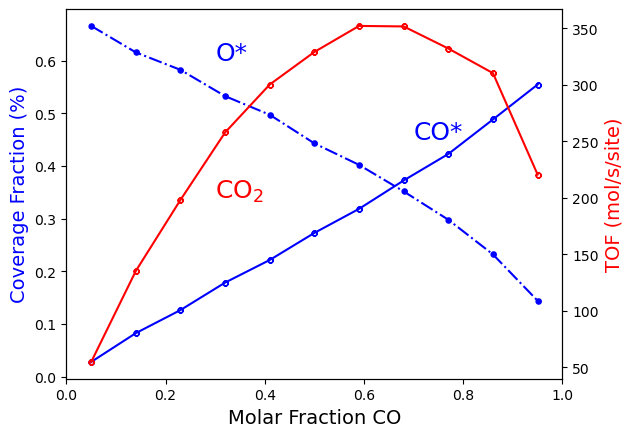

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes()
ax.set_xlim([0.0, 1.0])
ax.set_xlabel('Molar Fraction CO', fontsize=14)
ax.set_ylabel('Coverage Fraction (%)', color='blue', fontsize=14)
ax.plot(x_CO, ac_O, marker='$\u25CF$', color='blue', linestyle='-.', markersize=4, zorder=2)
ax.plot(x_CO, ac_CO, marker='$\u25EF$', color='blue', markersize=4, zorder=4)
plt.text(0.3, 0.60, 'O*', fontsize=18, color='blue')
plt.text(0.7, 0.45, 'CO*', fontsize=18, color='blue')

ax2 = ax.twinx()
ax2.set_ylabel('TOF (mol/s/site)',color='red', fontsize=14)
ax2.plot(x_CO, TOF_CO2, marker='$\u25EF$', color='red', markersize=4, zorder=6)
plt.text(0.3, 200.0, 'CO$_2$', fontsize=18, color='red')

plt.show()

Starting from the left side of the figure, it shows that by increasing
the ``x_CO``; the net $CO$ oxidation reaction tends to progress more quickly
(like a first-order reaction). Then the reaction rate peaks at around
``x_CO=0.7``, becoming almost independent of ``x_CO`` (like a zero-order
reaction). And finally, it then begins to decline (like a negative-order
reaction). Furthermore, we can see that as we increase the coverage of $CO*$,
we decrease the coverage of $O*$. As a result, when we mostly cover the
surface with one of the reactants (either $CO*$ or $O*$), the rate of $CO_2$
production becomes slow because there isn't enough of the complementary
reactant on the surface. So, it is not a surprise, that the maximum $CO_2$
generation coincides with the point at which $CO*$ coverage equals $O*$
coverage.

In the Zacros tutorial [What's KMC All About and Why Bother?](https://zacros.org/tutorials/12-about-kinetic-monte-carlo?showall=1),
there is a thorough discussion of Langmuir-Hinshelwood-type models, their
approximations with respect to a real system, and how to obtain analytical
expressions for reactant coverages and the net reaction rates concerning
gas phase composition. In particular, these expressions are reached by
making the fundamental assumption that both diffusion and
adsorption/desorption events are quasi-equilibrated (being the later one
the rate-limiting factor), occurring on a much faster timescale than the
oxidation event. We use the same argument to speed up our calculations.
Thus, we can use the analytical expressions we obtained to assess the
overall quality of our results. Our results should be indistinguishable
from the Langmuir-Hinshelwood deterministic equations, which are shown
below:

$$
\begin{gather}
\theta_\text{O} = \frac{ \sqrt{B_{\text{O}_2}x_{\text{O}_2}} }{ 1 + B_\text{CO}x_\text{CO} + \sqrt{B_{\text{O}_2}x_{\text{O}_2}} } \\
\theta_\text{CO} = \frac{ B_\text{CO}x_\text{CO} }{ 1 + B_\text{CO}x_\text{CO} + \sqrt{B_{\text{O}_2}x_{\text{O}_2}} } \\[7mm]
\text{TOF}_{\text{CO}_2} = 6 \, A_\text{oxi}\theta_\text{CO}\theta_\text{O}
\end{gather}
$$

Here $B_\text{CO}$/$B_{\text{O}_2}$ represent the ratio of the adsorption-desorption
pre-exponential terms of $CO$/$O_2$ (``pe_ratio`` in Zacros), $x_\text{CO}$/$x_{\text{O}_2}$
the molar fractions of $CO$/$O_2$; $\theta_\text{CO}$/$\theta_\text{O}$
the coverage of $CO*$/$O*$, $A_\text{oxi}$ the pre-exponential factor of the
CO oxidation step (``pre_expon`` in Zacros), and TOF$_{\text{CO}_2}$ the turnover
frequency or production rate of $CO_2$. The number 6 is because, in our lattice,
each site has 6 neighbors, so the oxidation event is "replicated" across
each neighboring site.

Notice that to get the above expressions based on the ones shown in the Zacros
tutorial, you need the following equalities:

$$
\begin{gather}
K_s P_s = \left( \frac{A^\text{ads}_s P^{-1}}{A^\text{des}_s} \right) x_s P = B_s x_s \qquad \therefore\qquad s=\text{CO},\text{O}_2
\\
k_\text{oxi} = A_\text{oxi}
\end{gather}
$$

The final equality follows from the fact that in pyZacros, the activation energy
for all elementary reactions is equal to zero.

The code below simply computes the coverages and TOF of $CO_2$ using the analytical
expression described above: 

In [16]:
import numpy

lh = pz.models.LangmuirHinshelwood()

B_CO = lh.mechanism.find_one( 'CO_adsorption' ).pe_ratio
B_O2 = lh.mechanism.find_one( 'O2_adsorption' ).pe_ratio
A_oxi = lh.mechanism.find_one( 'CO_oxidation' ).pre_expon

x_CO_model = numpy.linspace(0.0,1.0,201)

ac_O_model = []
ac_CO_model = []
TOF_CO2_model = []

for i in range(len(x_CO_model)):
    x_O2 = 1 - x_CO_model[i]
    ac_O_model.append( numpy.sqrt(B_O2*x_O2)/( 1 + B_CO*x_CO_model[i] + numpy.sqrt(B_O2*x_O2) ) )
    ac_CO_model.append( B_CO*x_CO_model[i]/( 1 + B_CO*x_CO_model[i] + numpy.sqrt(B_O2*x_O2) ) )
    TOF_CO2_model.append( 6*A_oxi*ac_CO_model[i]*ac_O_model[i] )

Additionally, if you have installed the package [matplotlib](https://matplotlib.org/),
you can see the aforementioned results visually. Please look over the code below, and
notice we plot the analytical and simulation results together. The points in the
figure represent simulation results, while the lines represent analytical model results.
They are nearly identical. 

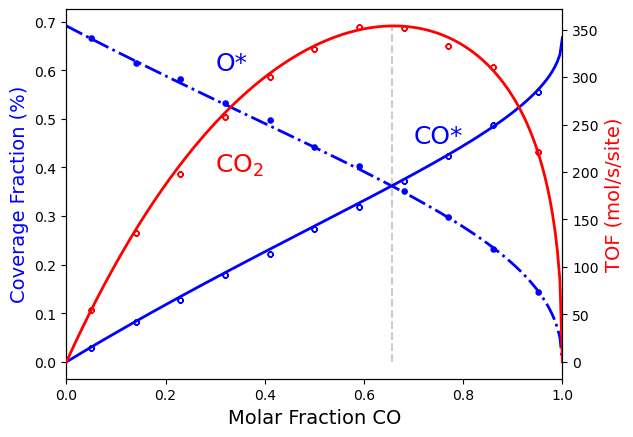

In [13]:
import matplotlib.pyplot as plt

x_CO_max = (K_O2/K_CO**2/2.0)*(numpy.sqrt(1.0+4.0*K_CO**2/K_O2)-1.0)

fig = plt.figure()

ax = plt.axes()
ax.set_xlim([0.0, 1.0])
ax.set_xlabel('Molar Fraction CO', fontsize=14)
ax.set_ylabel('Coverage Fraction (%)', color='blue', fontsize=14)
ax.vlines( x_CO_max, 0, max(ac_O_model), colors='0.8', linestyles='--',)
ax.plot(x_CO_model, ac_O_model, color='blue', linestyle='-.', lw=2, zorder=1)
ax.plot(x_CO, ac_O, marker='$\u25CF$', color='blue', lw=0, markersize=4, zorder=2)
ax.plot(x_CO_model, ac_CO_model, color='blue', linestyle='-', lw=2, zorder=3)
ax.plot(x_CO, ac_CO, marker='$\u25EF$', color='blue', markersize=4, lw=0, zorder=4)
plt.text(0.3, 0.60, 'O*', fontsize=18, color='blue')
plt.text(0.7, 0.45, 'CO*', fontsize=18, color='blue')

ax2 = ax.twinx()
ax2.set_ylabel('TOF (mol/s/site)',color='red', fontsize=14)
ax2.plot(x_CO_model, TOF_CO2_model, color='red', linestyle='-', lw=2, zorder=5)
ax2.plot(x_CO, TOF_CO2, marker='$\u25EF$', color='red', markersize=4, lw=0, zorder=6)
plt.text(0.3, 200.0, 'CO$_2$', fontsize=18, color='red')

plt.show()

As a final note, we included in the code above the value of the $CO$ molar fraction
($x_\text{CO}^*$) on which we get the maximum $CO 2$ production rate. The figure shows
this value as a vertical gray dashed line. It is simple to deduce it from the
preceding analytical expressions: 

$$
x_{CO}^* = \frac{B_{\text{O}_2}}{2 B_\text{CO}^2}\left( \sqrt{1+\frac{4 B_\text{CO}^2}{B_{\text{O}_2}}} - 1 \right)\approx 0.656
$$

Notice that the position of this maximum $x_\text{CO}*$ depends exclusively on the ratio
of the ``pe_ratio`` parameters for $CO$ and $O_2$ in the Langmuir-Hinshelwood model.